<a href="https://colab.research.google.com/github/Kfin2343/riboswitches/blob/main/Honors_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#function setup & data pre-processing 

In [143]:
!pip install biopython

In [144]:
import os, requests, io
import numpy as np
import pandas as pd
import glob
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, f1_score, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm
import statistics
from statistics import mean
from sklearn.preprocessing import StandardScaler
import random
from Bio import Align
from Bio.Align import substitution_matrices
from Bio import pairwise2

In [145]:
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

In [146]:
##### REMOVE OUTLIERS BY TAKING SWITCHES OF LENGTH 50 TO 110 #######
num =  80
var = 50
#### IMPORT FAMILIES 
#sets = ['Fluoride', 'Glutamine', 'Glycine', 'Purine', 'ZMP']
#sets = ['Fluoride', 'Glutamine', 'Glycine', 'Purine', 'ZMP', 'FMN', 'SAMIIV', 'TPP', 'nhaA']
#sets = ['Glutamine', 'Glycine', 'ZMP']
sets = ['Glycine']
num_classes = 1
fam_len = []
fam_sequences = []
lll = []
for u in sets:
  url = 'https://raw.githubusercontent.com/Kfin2343/riboswitches/main/{}_riboswitch.csv'.format(u)
  s=requests.get(url).content
  df=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ",") #pandas datatframe
  sequence1 = np.asarray(df['0'])
  exact_len = []
  ll = []
  for i in range(len(sequence1)): 
    l = len(sequence1[i])
    ll.append(l)
    if num-var< l < num+var: #only accept lengths between 50 and 110
      a = sequence1[i]
      exact_len.append(a)
  sequence = np.asarray(exact_len) #convert to numpy array
  sequence = np.expand_dims(sequence, 1) #2d array
  fam_len.append(len(sequence))  #class size, used for label creation
  fam_sequences.append(sequence) 
  lll.append(mean(ll))
ex_seq = fam_sequences[0] #needed for concatenating along new dim (below)
for i in range(1,len(fam_len)):
  ex_seq = np.concatenate((ex_seq, fam_sequences[i]))
ex_seq = np.squeeze(ex_seq)

###create classification label vector
fam_idx = [] 
for i in range(1, len(fam_len)+1):
  a = np.empty((fam_len[i-1], 1))
  a.fill(i)
  fam_idx.append(a)
fam_id = np.concatenate((fam_idx), axis = 0)

###convert label to one hot encoded vector
enc = OneHotEncoder()
enc.fit(fam_id) 
family_id = enc.transform(fam_id).toarray()
family_id = torch.tensor(family_id).double().to(device)

print(lll)
for i in range(num_classes):
  print(len(fam_sequences[i])) #family counts

[95.50765637165844]
3853


In [147]:
def sequence_one_hot(sequence_array):
 
 
  seq_list = []
  
  for a in sequence_array:
    split = []
    split = [char for char in a]
    seq_list.append(split)

  resnames = ['G', 'T', 'A', 'C']
    
  label_encoder = LabelEncoder()
  encode_names = label_encoder.fit_transform(resnames)
  code = dict(zip(resnames, encode_names))

  sequences = []
  for i in range(len(seq_list)):
    position_sequence = []
    for r in seq_list[i]:
      position = code[r]
      position_sequence.append(position)
    
    values = np.asarray(position_sequence).reshape(len(position_sequence), 1)
    onehot_encoder = OneHotEncoder(sparse=False) #build encoder
    enc = encode_names.reshape(len(encode_names),1) #reshape into two dimensions before fitting
    onehot_encoder.fit(enc)  #assign constant 'code' for one hot encoding from 'resnames' list above
    encoded_matrix = onehot_encoder.transform(values) #convert to [x,20] dimensions, one hot encoded
    sequences.append(encoded_matrix)

  lx = []
  lenx = []

  for a in sequences: 
      tensor = torch.tensor(a) #convert to tensor
      lx.append(tensor) #append to list
      lenx.append(a.shape[0]) #need length for pack_padded_sequence

  padded_sequence = pad_sequence(lx, padding_value=0)

  return padded_sequence, lenx

padded_sequence, lengths = sequence_one_hot(sequence_array = ex_seq) #processed data
padded_sequence = padded_sequence.double() #dtype
padded_sequence = padded_sequence.to(device) #cast to gpu
lengths = torch.tensor(lengths).double().to(device)

In [148]:
def find_similar(seq):
  similarity_list = []
  seqsplit = split(seq)
  for ii in range(len(ex_seq)):  
    iq = ex_seq[ii]
    gensplit = split(iq)
    tally = 0
    for i in range(len(seqsplit)):
      a= seqsplit[i]
      if i<len(gensplit):
        b= gensplit[i]
        if a==b:
          tally+=1
        else:
          pass
      else:
        pass
    a = tally/len(seqsplit)
    similarity_list.append(a)

  return max(similarity_list)



In [149]:

class dataset_rnn(data.Dataset):
  def __init__(self, x, y, l):
    self.x = x
    self.y = y
    self.l = l
  def __len__(self):
    return len(self.x[0,:,0])
  def __getitem__(self, index):
    X = self.x[:, index, :]
    Y = self.y[index,:]
    L = self.l[index]
    return X, Y, L

In [150]:
class dataset(data.Dataset):
  def __init__(self, x, t, l):
    self.x = x
    self.t = t
    self.l = l
  def __len__(self):
    return len(self.x[0,:,0])
  def __getitem__(self, index):
    X = self.x[:, index, :]
    T = self.t[index, :]
    L = self.l[index]
    return X, T, L

In [151]:
all_index = np.arange(0, len(family_id[:,0]))
train_index = []
fcs = np.cumsum(fam_len)
for i in range(num_classes):
  if i == 0:
    ix = random.sample(range(0, fcs[0]), 9*len(fam_sequences[i])//10)
    train_index.append(ix)
  else:
    ix = random.sample(range(fcs[i-1], fcs[i]), 9*len(fam_sequences[i])//10)
    train_index.append(ix)
    
a = []
for i in train_index:
  for x in i:
    a.append(x)

train_index = np.asarray(a).flatten()
rng = np.random.default_rng()
rng.shuffle(train_index)
print(train_index.shape)
test_index = np.delete(all_index, train_index)


train_index = torch.tensor(train_index).to(device)
valid_index = torch.tensor(test_index).to(device)

print(train_index.shape, test_index.shape)

(3467,)
torch.Size([3467]) (386,)


In [152]:
train_x = padded_sequence[:,train_index,:]
train_length = lengths[train_index]
test_length = lengths[valid_index]
test_x = padded_sequence[:,valid_index,:]
train_y = family_id[train_index,:]
test_y = family_id[valid_index,:]

In [153]:
def generate_report(predicted, ground_truth):

  predicted = predicted.reshape(predicted.size(0), num_classes).to('cpu')
  predicted = np.asarray(predicted.detach())
  pred_binary = np.zeros_like(predicted)
  pred_binary[np.arange(len(predicted)), predicted.argmax(1)] = 1
  ground_truth = np.asarray(ground_truth.to('cpu'))
  matrix = classification_report(ground_truth, pred_binary, digits=4)
  f1 = f1_score(ground_truth, pred_binary, average='macro')
  targets = []
  for i in range (num_classes):
    a = str(i)
    targets.append(a)
  ##targets = ['1', '2', '3', '4', '5']
  colors = cm.rainbow(np.linspace(0, 1, len(targets)))
  plt.figure()
  lw = 3
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i, target in enumerate(targets):
    fpr[i], tpr[i], thresholds = roc_curve(ground_truth[:,i], predicted[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(num_classes):
      plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                        ''.format(i, roc_auc[i]))  # roc_auc_score

  avg_score = mean(roc_auc[k] for k in roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc=(1.1,0))
  #plt.show()

  return plt, matrix, avg_score, f1


In [154]:
def split(word): 
    return list(word)

In [155]:
def process_generated(gen):
  test = gen.reshape(padded_sequence.size(0),4).to('cpu')
  test = np.asarray(test.detach())

  pred_binary = np.zeros_like(test)
  pred_binary[np.arange(len(test)), test.argmax(1)] = 1

  a = np.sum(test, 1)

  #plt.plot(a)
  #plt.show()

  stop_point = []
  for i, j in enumerate(a):
    if j <=.2:
      stop_point.append(i)

  #print(stop_point[0:4])
  if not stop_point:
    pass
  elif stop_point[0] <= 40:
    pass
  else:
    pred_binary = pred_binary[:stop_point[0],:]

  s = []
  for i in pred_binary:
    if i[0] == 1:
      s.append('A')
    elif i[1] == 1:
      s.append('C')
    elif i[2] == 1:
      s.append('G')
    elif i[3] == 1:
      s.append('T')

  result = ''
  for element in s:
      result += str(element)

  generated = [result]

  seq, _ = sequence_one_hot(generated)
  #print(seq.size(0))
  zeros = torch.zeros((padded_sequence.size(0)-seq.size(0),1,4))
  generated_sequence = torch.cat((seq, zeros))


  g = generated_sequence.permute(1,0,2)
  g = g.to(device)
  
  return result, g


In [156]:
def cyclic_anneal(epoch, epochs, num_cycles):
  cycle_length = epochs//num_cycles
  #seperate first x cycles and last cycle
  cycle_list = []
  for i in range(1,num_cycles+1):
    if i == num_cycles:
      cycle_list.append(epochs)
    else:
      a = cycle_length*i
      cycle_list.append(a)

  if epoch <= cycle_list[0]:
    if epoch < cycle_length //2:
      beta = epoch/(cycle_length//2)
    else:
      beta = 1
  else:
    pass

  for ii in cycle_list:
    r = epoch/ii
    if 1<r<=2:
      a = epoch-ii
      if a < cycle_length //2:
        beta = a/(cycle_length//2)
      else:
        beta = 1
    else:
      pass

  return beta

for i in range(100):
  a = cyclic_anneal(i, 100, 3)

  

# vae

##model

In [157]:
 class VAE(nn.Module):
    def __init__(self, in_dims=1, hid1_dims=1, hid2_dims=8, num_classes=num_classes, negative_slope=0.1):
        super(VAE, self).__init__()
        self.in_dims = in_dims
        self.hid1_dims = hid1_dims
        self.hid2_dims = hid2_dims
        self.num_classes = num_classes
        self.negative_slope = negative_slope

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_dims+num_classes, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU() #nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
        )
        self.fc_mu = nn.Linear(128, hid1_dims)
        self.fc_var = nn.Linear(128, hid1_dims)

        # Conditioner
        self.conditioner = nn.Sequential(
            nn.Linear(num_classes, 16),
            nn.ReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(16,32),
            nn.ReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(32, hid2_dims),
            nn.ReLU() #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hid1_dims+num_classes, 128), 
            nn.BatchNorm1d(128),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(512, 512), 
            nn.BatchNorm1d(512),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(512, in_dims),
            nn.Sigmoid()
        )

        self._init_weights()

    def forward(self, x, y):
        x = torch.cat([x,y], dim=1)
        # Encode input
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_var(h)
        hx = self._reparameterize(mu, logvar)
        # Encode label
        h = torch.cat([hx,y], dim = 1)
        # Decode
        y_ = self.decoder(h)
        return y_, mu, logvar

    def generate(self, y):
        hy = self.conditioner(y)
        hx = self._sample(y.shape[0]).type_as(hy)
        h = torch.cat([hx, hy], dim=1)
        h = torch.cat([hx,y], dim = 1)
        y = self.decoder(h)
        return y

    def generate_similar(self,l,y):
      h = torch.cat([l,y], dim=1)
      z = self.decoder(h)
      return(z)


    def encode(self, x):
      x = torch.cat([x,y], dim=1)
      l1 = self.encoder(x)
      mu, logvar = self.fc_mu(l1), self.fc_var(l1)
      l2 = self._reparameterize(mu, logvar)
      return l2

    def _represent(self, x):
        x = torch.cat([x,y], dim=1)
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_var(h)
        hx = self._reparameterize(mu, logvar)
        return hx

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).type_as(mu)
        z = mu + std * esp
        return z


    def _sample(self, num_samples):
        return torch.FloatTensor(num_samples, self.hid1_dims).normal_()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

##VAE loss function

In [158]:
# return reconstruction error + KL divergence losses
def vae_loss_function(recon_x, x, mu, log_var, epoch,cycles):
    BCE = F.binary_cross_entropy(recon_x.flatten(), x.flatten(), reduction='sum')
    KLD = (-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())-5)*cyclic_anneal(epoch, vae_epochs, cycles) 
    return BCE + 5*KLD, KLD/(KLD+BCE)  #see Serena Yeung et. al. 

##train/test

In [159]:

def train_vae(epoch, opt, loader):
  train_loader = loader
  vae.train()
  train_loss = 0
  for batch_idx, (x,c, l) in enumerate(train_loader):
      opt.zero_grad()
      x = x.reshape(x.size(0), 4*x.size(1))
      recon_batch, mu, log_var = vae(x,c)
      loss, KL = vae_loss_function(recon_batch, x, mu, log_var, epoch,cycles)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(vae.parameters(), 4)
      train_loss += loss.item()
      opt.step()
        

  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)), 'KL:', KL.item())

In [160]:
def test_vae(epoch, loader):
  test_load = loader
  vae.eval()
  test_loss = 0
  for batch_idx, (x,c, l) in enumerate(test_load):
      x = x.reshape(x.size(0), 4*x.size(1))
      recon_batch, mu, log_var = vae(x,c)
      loss = F.binary_cross_entropy(recon_batch.flatten(), x.flatten(), reduction='sum')
      test_loss += loss.item()

        

  print('====> test loss: {:.4f}'.format(test_loss / len(test_load.dataset)))

##hyperparam, build, run

In [161]:
batch_size_vae = 100
vae_epochs = 100
latent_size = 16
conditional_size = 32 ##ignore
cycles = 4

In [162]:
# build model
vae = VAE(in_dims=4*(padded_sequence.size(0)), hid1_dims = latent_size, hid2_dims = conditional_size, num_classes=num_classes, negative_slope=.01).double()
vae = vae.to(device)
optimizer_vae = torch.optim.Adam(vae.parameters(), lr = .001)

In [163]:
#rng = np.random.default_rng()
#rng.shuffle(vae_index)
train_index = range(len(train_x[0,:,0]))
test_index = random.sample(range(len(valid_index)), 100)
vae_train_loader = data.DataLoader(dataset(train_x[:,train_index,:], train_y[train_index,:], train_length[train_index]), batch_size = batch_size_vae)
vae_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = batch_size_vae)

In [164]:
for epoch in range(vae_epochs):
    train_vae(epoch, optimizer_vae, vae_train_loader)
    test_vae(epoch, vae_test_loader)

====> Epoch: 0 Average loss: 209.5800 KL: 0.0
====> test loss: 189.2782
====> Epoch: 1 Average loss: 185.8593 KL: 0.0039037912932388245
====> test loss: 178.2732
====> Epoch: 2 Average loss: 181.5972 KL: 0.006311909304083413
====> test loss: 174.1573
====> Epoch: 3 Average loss: 179.7003 KL: 0.00815982019623588
====> test loss: 170.7713
====> Epoch: 4 Average loss: 178.0824 KL: 0.010480999604886005
====> test loss: 169.0128
====> Epoch: 5 Average loss: 177.3114 KL: 0.012707793075703572
====> test loss: 165.8531
====> Epoch: 6 Average loss: 177.1960 KL: 0.015026491890019204
====> test loss: 164.4077
====> Epoch: 7 Average loss: 177.2303 KL: 0.01701149975719807
====> test loss: 164.0152
====> Epoch: 8 Average loss: 177.7188 KL: 0.018864915717590573
====> test loss: 162.9447
====> Epoch: 9 Average loss: 178.7724 KL: 0.021095214129662587
====> test loss: 161.7223
====> Epoch: 10 Average loss: 179.5039 KL: 0.022088455808088464
====> test loss: 163.4658
====> Epoch: 11 Average loss: 180.3531

##eval

In [186]:
variability = 0.0
number_samples = 1
test_index = random.sample(range(len(train_index)), 300)
ys = []
ls = []
l1 = []
ids = []
G_content = []
scan_similarity = []
input_similarity = []
for i in range(len(sets)):
  ids.append(i)
l_di = dict(zip(ids, sets))
vae_test_loader = data.DataLoader(dataset(train_x[:,test_index,:], train_y[test_index,:], train_length[test_index]), batch_size = 1)
for iii, (x,y,l) in enumerate(vae_test_loader):
  x1 = x.reshape(x.size(0), 4*x.size(1))
  seq,_ = process_generated(x1)
  seqsplit = split(seq)
  Gcontent = 0
  for i in range(len(seqsplit)):
    a = seqsplit[i]
    if a == 'T':
      Gcontent +=1
  G_content.append(Gcontent)
  #print(y)
  latent_space = vae.encode(x1)
  ##print('\n', latent_space)
  ls.append(latent_space.to('cpu').detach().numpy())
  ys.append(y.to('cpu').detach().numpy())
  l1.append(l.to('cpu').detach().numpy())
  yi = int(np.asarray(y.to('cpu')).argmax(1))
  yid = l_di[yi]
  if iii <10:
    print('\n >{} input \n'.format(yid), seq) 
  
  for ii in range(number_samples):
    noise = torch.randn((latent_space.shape))*variability
    noise = noise.double().to(device)
    sampled = noise+latent_space
    gen = vae.generate_similar(sampled, y)
    gen_seq, gen_code = process_generated(gen=gen)
    if iii<10:
      print('>{}{}_generated \n'.format(yid, ii+1), gen_seq)
    else:
      pass
    seqsplit = split(seq)
    gensplit = split(gen_seq)
    tally = 0
    for i in range(len(seqsplit)):
      a= seqsplit[i]
      if i<len(gensplit):
        b= gensplit[i]
        if a==b:
          tally+=1
        else:
          pass
      else:
        pass

    sim = tally/len(seqsplit)
    mostsim = find_similar(gen_seq)
    input_similarity.append(sim)
    scan_similarity.append(mostsim)

    if iii<10:
      q = iii
      print('% similarity', sim)
      print('most similar in training set:',mostsim)
    else:
      pass
      
        

      

  else:
    pass



print('\n \n mean input similarity', mean(input_similarity))
print('mean scanned similarity', mean(scan_similarity))


 >Glycine input 
 GGCCCCGCGCAGGGAGAGACCGGCCAGGAGCCGGCGCCGAAGGAGCAACCGCCCCGGAAACTCTCAGGCACAAAGGACCGGCGCGGGACG
>Glycine1_generated 
 CCCCGCCCCGCGGGAGAGACTGGCTTCACGCCGGCGCCGAAGGAGCAACCGCCCCGGAAACTCTCAGGCAAACGGACCGGGCGGGGGCT
% similarity 0.7444444444444445
most similar in training set: 0.8089887640449438

 >Glycine input 
 AAGATCAATACTGGAGAGCACGATGAGTCGTCGCCGAAGGAGCAAGCCGTCAAGGTGAATCTCTCAGGTAAAAGAACAGTATTGTGACG
>Glycine1_generated 
 ATGACTACAGCGGGAGAGACTACTTAAGTGGCGCCGAAGGAGCAAGCACTCCCCGTGAATCTCTCAGGCAAACGGACCGCTGTAGGACG
% similarity 0.651685393258427
most similar in training set: 0.8426966292134831

 >Glycine input 
 TGATCTCGTGCGGGAGAGCACCCACACCAACCCAGTGTGGGTCACCGAAGGAGCAACTCCTCTCCGACAAACTCTCAGGTCCCCGTACCGCACGGGCCAG
>Glycine1_generated 
 CGATCCGCGGCGGGAGAGTCCCGCCCGCCCGCACCGGGCGGGCGCCGTAGGAGCAAATCCTCCCCGGGAATCTCTCAGGCACCCGGAACGCCGCCGACAGG
% similarity 0.63
most similar in training set: 0.8217821782178217

 >Glycine input 
 CGGGGTCGAGCGGGAGAGTTCAGCGATTCGTCTGACGCCGAAGGAGCAATGTCCCGGAATCTCTCA

In [167]:
glycine1 =  torch.tensor([[ 0.8786, -2.5213,  1.3548,  0.4012, -0.8996, -1.0660, -0.1862,  1.4701,
          0.0578, -1.3307,  1.1065,  1.7855, -0.1441,  0.4214,  1.1755,  0.0341]])
glycine2 =  torch.tensor([[ 1.5450,  1.2961,  1.7923,  0.3352,  0.6877, -0.4763,  0.5722, -0.3662,
         -1.3082, -0.0468, -2.6488, -1.4083, -0.1070, -0.9566, -0.1814,  1.7470]])
dif = glycine2-glycine1

steps = 5

step = dif/steps
yy = torch.tensor([[0,1,0]]).to(device).double()
for i in range(steps+1):
  latent_step = glycine1 + i*step
  latent_step = latent_step.to(device).double()
  gen = vae.generate_similar(latent_step, yy)
  gen_seq, gen_code = process_generated(gen=gen)
  print(gen_seq)




  






RuntimeError: ignored

In [ ]:
dif = glycine1-glycine2


(300, 16)


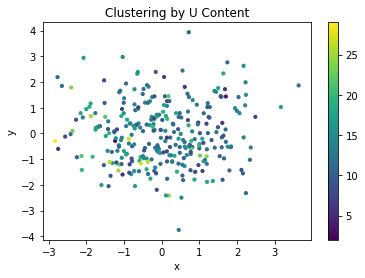

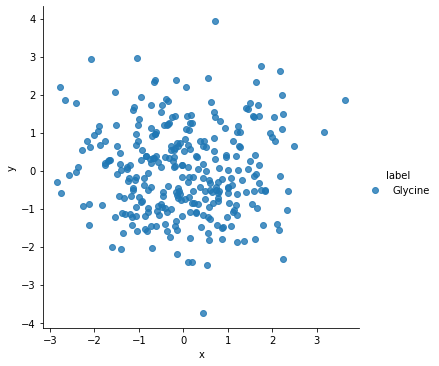

In [187]:
latent_space_total =ls[0]
for i in range(1,len(ls)):
  l = ls[i]
  latent_space_total = np.concatenate((latent_space_total,l), axis=0)

print(latent_space_total.shape)

ys_total =ys[0]
for i in range(1,len(ys)):
  y = ys[i]
  ys_total = np.concatenate((ys_total,y), axis=0)
ys_total = ys_total.argmax(1).reshape(-1,1)

l1_total = l1[0]
for i in range(1, len(l1)):
  l = l1[i]
  l1_total = np.concatenate((l1_total, l), axis=0)

G_total = G_content[0]
for i in range(1,len(G_content)):
  g = G_content[i]
 # G_total = np.concatenate((G_total, g), axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(latent_space_total)

ids = []
for i in range(len(sets)):
  ids.append(i)

l_di = dict(zip(ids, sets))

ribo_labels = pd.DataFrame(ys_total)
ribo_labels = ribo_labels.replace(l_di)

pcs = pd.DataFrame(pcs)

pcs_data = pd.concat((pcs, ribo_labels), axis=1)
pcs_data.columns = ['x', 'y', 'label']

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(pcs_data['x'], pcs_data['y'], c=G_content, s=10)
ax.set_title('Clustering by U Content')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

import seaborn as sns

facet = sns.lmplot(data=pcs_data, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

# rnn vae

##model

In [32]:
 class RNN_VAE(nn.Module):
    def __init__(self, in_dims=1, hid1_dims=1, embedsize=8, num_classes=num_classes, hsize=256, num_layers = 1):
        super(RNN_VAE, self).__init__()
        self.in_dims = in_dims
        self.hid1_dims = hid1_dims
        self.embedsize = embedsize
        self.num_classes = num_classes
        self.drop_p = .3
        self.num_layers = num_layers
        self.hsize = hsize
        
        self.embed = nn.Embedding(4,self.embedsize)

        self.gru = nn.GRU(input_size=self.embedsize, hidden_size= self.hsize, num_layers= num_layers, bidirectional= True, batch_first = True)
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(2*self.hsize*self.num_layers, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128)
        )

        self.transform = nn.Sequential(nn.LeakyReLU())
        self.fc_mu = nn.Linear(128, hid1_dims)
        self.fc_var = nn.Linear(128, hid1_dims)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.hid1_dims+num_classes, 256), 
            nn.BatchNorm1d(256),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, in_dims),
            nn.Sigmoid()
        )

        self._init_weights()

    def forward(self, x, y):
        ##self.hidden = self.init_hidden(x.size(0)).to(device)
        ind = x.argmax(2).type(torch.LongTensor)
        ind = ind.to(device)
        x = self.embed(ind)
        x = x.double()
        gru_out, h = self.gru(x) ##, self.hidden)
        h = h.permute(1,2,0).contiguous()
        h = torch.flatten(h, start_dim=1, end_dim = 2).contiguous()
        # Encode input
        #h = torch.cat([h,y], dim=1)
        h2 = self.encoder(h)
        #h = self.transform(h)
        mu, logvar = self.fc_mu(h2), self.fc_var(h2) 
        hx = self._reparameterize(mu, logvar)
        h = torch.cat([hx,y], dim = 1)
        # Decode
        y_ = self.decoder(h) ####h
        return y_, mu, logvar

    def generate(self, y):
        hx = self._sample(y.shape[0]).type_as(hy)
        h = torch.cat([hx,y], dim = 1)
        y = self.decoder(h) ####h
        return y

    def generate_similar(self,l,y):
      h = torch.cat([l,y], dim=1)
      z = self.decoder(h) ####z
      return z 


    def encode(self, x,y):
        ##self.hidden = self.init_hidden(x.size(0)).to(device)
        ind = x.argmax(2).type(torch.LongTensor)
        ind = ind.to(device)
        x = self.embed(ind)
        x = x.double()
        gru_out, h = self.gru(x) ##, self.hidden)
        h = h.permute(1,2,0).contiguous()
        h = torch.flatten(h, start_dim=1, end_dim = 2)
        # Encode input
       # h = torch.cat([h,y], dim=1)
        h2 = self.encoder(h)
        h = self.transform(h)
        mu, logvar = self.fc_mu(h2), self.fc_var(h2)
        l2 = self._reparameterize(mu, logvar)
        return l2

 #   def _represent(self, x):
         ##self.hidden = self.init_hidden(x.size(0)).to(device)
  #      gru_out, h = self.gru(x) ##, self.hidden)
   #     h = h.permute(1,2,0)
    #    h = torch.flatten(h, start_dim=1, end_dim = 2)
        # Encode input
     #   h2 = self.encoder(h)
      #  mu, logvar = self.fc_mu(h2), self.fc_var(h2)
       # hx = self._reparameterize(mu, logvar)
        #return hx

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).type_as(mu)
        z = mu + std * esp
        return z


    def _sample(self, num_samples):
        return torch.FloatTensor(num_samples, self.hid1_dims).normal_()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

##RNNVAE loss function

In [33]:
# return reconstruction error + KL divergence losses
def rnnvae_loss_function(recon_x, x, mu, log_var, epo):
    BCE = F.binary_cross_entropy(recon_x.flatten(), x.flatten(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())*cyclic_anneal(epoch, vae_epochs, cycles)
    return BCE + 1.5*KLD #see Serena Yeung et. al. for KL scaling factor explanation


##train/test

In [34]:
def train_rnn_vae(epoch, opt, loader):
  train_loader = loader
  rnnvae.train()
  train_loss = 0
  for batch_idx, (x,c,l) in enumerate(train_loader):
      x = x.double().to(device)
      l = l.to('cpu')
      pack = torch.nn.utils.rnn.pack_padded_sequence(x, l , batch_first=True, enforce_sorted=False)
      opt.zero_grad()
      #x = x.reshape(x.size(0), 4*x.size(1))
      recon_batch, mu, log_var = rnnvae(x,c)
      loss = rnnvae_loss_function(recon_batch, x, mu, log_var, epoch)
      loss.backward()
      train_loss += loss.item()
      opt.step()
        

  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test_rnnvae(epoch, loader):
  test_load = loader
  rnnvae.eval()
  test_loss = 0
  for batch_idx, (x,c,l) in enumerate(test_load):
      #x = x.reshape(x.size(0), 4*x.size(1))
      l = l.to('cpu')
      pack = torch.nn.utils.rnn.pack_padded_sequence(x, l , batch_first=True, enforce_sorted=False)
      recon_batch, mu, log_var = rnnvae(x,c)
     ## loss = F.mse_loss(x.flatten(), recon_batch.flatten(), reduction = 'sum')
      loss = F.binary_cross_entropy(recon_batch.flatten(), x.flatten(), reduction='sum')
      test_loss += loss.item()

        

  print('====> test loss: {:.4f}'.format(test_loss / len(test_load.dataset)))

##hyperparam, build, run

In [35]:
batch_size_vae =  200
vae_epochs = 300
latent_size = 16
cycles = 10

In [36]:
# build model

rnnvae = RNN_VAE(in_dims=4*(padded_sequence.size(0)), hid1_dims = latent_size, embedsize= 4, num_classes=num_classes, hsize=150, num_layers=1).double()
rnnvae = rnnvae.to(device)
optimizer_vae = torch.optim.Adam(rnnvae.parameters(), lr = .001)

In [37]:
#rng = np.random.default_rng()
#rng.shuffle(vae_index)
train_index = range(len(train_x[0,:,0]))
test_index = random.sample(range(len(valid_index)), 100)
vae_train_loader = data.DataLoader(dataset(train_x[:,train_index,:], train_y[train_index,:], train_length[train_index]), batch_size = batch_size_vae)
vae_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = batch_size_vae)

In [38]:
for epoch in range(vae_epochs):
    train_rnn_vae(epoch, optimizer_vae, vae_train_loader)
    test_rnnvae(epoch, vae_test_loader)

====> Epoch: 0 Average loss: 205.7485
====> test loss: 197.8079
====> Epoch: 1 Average loss: 178.7751
====> test loss: 175.4062
====> Epoch: 2 Average loss: 174.9705
====> test loss: 172.3601
====> Epoch: 3 Average loss: 173.3021
====> test loss: 169.2831
====> Epoch: 4 Average loss: 171.7949
====> test loss: 168.7139
====> Epoch: 5 Average loss: 170.6125
====> test loss: 168.3831
====> Epoch: 6 Average loss: 169.3544
====> test loss: 165.4524
====> Epoch: 7 Average loss: 168.6170
====> test loss: 164.6911
====> Epoch: 8 Average loss: 167.7456
====> test loss: 164.6482
====> Epoch: 9 Average loss: 167.2215
====> test loss: 164.9461
====> Epoch: 10 Average loss: 166.5682
====> test loss: 161.9267
====> Epoch: 11 Average loss: 166.4362
====> test loss: 160.7019
====> Epoch: 12 Average loss: 166.0647
====> test loss: 160.8958
====> Epoch: 13 Average loss: 165.6598
====> test loss: 159.1403
====> Epoch: 14 Average loss: 165.4664
====> test loss: 160.9619
====> Epoch: 15 Average loss: 165.1

##EVAL

In [43]:
variability = 0.0
number_samples = 1
test_index = random.sample(range(len(train_index)), 10)

ys = []
ls = []
l1 = []
ids = []
scan_similarity = []
input_similarity = []
for i in range(len(sets)):
  ids.append(i)
l_di = dict(zip(ids, sets))

vae_test_loader = data.DataLoader(dataset(train_x[:,test_index,:], train_y[test_index,:], train_length[test_index]), batch_size = 1)

for iii, (x,y,l) in enumerate(vae_test_loader):
  x1 = x.reshape(x.size(0), 4*x.size(1))
  seq,_ = process_generated(x1)
  #print(y)
  latent_space = rnnvae.encode(x,y)
  print('\n', latent_space)
  ls.append(latent_space.to('cpu').detach().numpy())
  ys.append(y.to('cpu').detach().numpy())
  l1.append(l.to('cpu').detach().numpy())
  yi = int(np.asarray(y.to('cpu')).argmax(1))
  yid = l_di[yi]
  if iii <10:
    print('\n >{} input \n'.format(yid), seq) 
  
  for ii in range(number_samples):
    noise = torch.randn((latent_space.shape))*variability
    noise = noise.double().to(device)
    sampled = noise+latent_space
    gen = rnnvae.generate_similar(sampled, y)
    gen_seq, gen_code = process_generated(gen=gen)
    if iii<10:
      print('>{} generated: {} \n'.format(yid, ii+1), gen_seq)
    else:
      pass
    seqsplit = split(seq)
    gensplit = split(gen_seq)
    tally = 0
    for i in range(len(seqsplit)):
      a= seqsplit[i]
      if i<len(gensplit):
        b= gensplit[i]
        if a==b:
          tally+=1
        else:
          pass
      else:
        pass
    sim = tally/len(seqsplit)
    mostsim = find_similar(gen_seq)
    input_similarity.append(sim)
    scan_similarity.append(mostsim)
    if iii<10:
      print('% similarity', sim)
      print('most similar in training set:',mostsim)
    else:
      pass

  else:
    pass

print('\n \n mean input similarity', mean(input_similarity))
print('mean scanned similarity', mean(scan_similarity))


 tensor([[-0.5822, -0.3255, -1.0272,  0.5643,  0.3247,  1.8544, -2.1924, -0.2996,
         -0.4415, -0.8155,  0.9912, -0.6549, -0.6659, -0.0915, -2.1740, -0.5521]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

 >Glycine input 
 GGACGAAACTCTGGAGAGACTCAAAAGAGCACCGAAGGGGAAAACTAATTTTTAGTGAAACTCTCAGGTAAAAGAACAGAGACATTTTT
>Glycine generated: 1 
 GGACGGACCTCTGGAGAGACTCTAAAGGGCACCGAAGGGGAAAGCCAAATATTTCTGAAACTCTCAGGGTAAAAGGAAAAGGAATTTTAT
% similarity 0.7752808988764045
most similar in training set: 0.8

 tensor([[-0.7492,  1.2485,  0.2813,  0.6320,  0.4749,  0.3811,  0.4732,  0.3413,
         -0.1413,  0.5333, -0.4301,  3.3614, -0.7986, -0.2171,  0.5082, -0.3239]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

 >Glycine input 
 TTCCGTTCCATGGGAGAGCGCAGATCAAGTCTGCCGCCGAAGGCGCAATTTCACCCGAAAACGCTCAGGTAAAAGGACCATGAAACCGGA
>Glycine generated: 1 
 GCAATTTTTGCAGGAGAGAGGACCTACAAAGGTCCCGCCGAAGGAGCAACCACCCCGGAAACTCTCAGGCAAAAGGACCGAAAAAATGTA
% similarity 0.

In [40]:
glycine1 = torch.tensor([[ 0.8636, -0.2653, -0.0748,  1.3591,  0.9868, -0.8168,  2.1340,  0.4987,
          0.1397, -1.0721,  0.6553,  0.0429, -0.4242, -0.1992, -0.1195, -1.1274]])

glycine2 = torch.tensor([[-0.9762, -0.8972, -1.9723,  2.8120,  1.2544, -0.4263,  1.0611,  0.4093,
          1.6840,  2.6942, -1.3499,  0.3113, -1.5799,  0.4376, -1.8718,  0.3846]])

dif = glycine2-glycine1

steps = 5

step = dif/steps
yy = torch.tensor([[0,1,0]]).to(device).double()
for i in range(steps+1):
  latent_step = glycine1 + i*step
  latent_step = latent_step.to(device).double()
  gen = rnnvae.generate_similar(latent_step, yy)
  gen_seq, gen_code = process_generated(gen=gen)
  print(gen_seq)


TCGCTCGGCAGGGGGAGAGACGGCCCTGGCCCAGGCGCCAAGGGACAACCGCCCCGGAAACTCTCAGGCAAAAGGACCGCGCCGCCGAA
TCACTCCGCACGGGGAGAGCCGGGCCTGGGCCCGCGGCCGAAGAAGCACCGGCCCGGGAACTCTCAGGCCAAAGGGCCGGCGCGCCGTCG
TCACCCCCCACGGGGAGATCCGGCCCTGGGCCCGGGGCCGAAGAAGCAACCGCCCCGGAAACTCTCAGGCAAAAGGACCGCGCGGCGTCG
GCACCCCCGGCGGGAGAATCCCGCCCGCGGCCGGCGGCCGAAGAAGCAACCGCCCCGGAAACCTCCCGGCCACAGGGCCGCCGGGGGCGG
GGACCCCCCGCGGGAGAGTCCCGCCCGCGACCGGCGCCCGAAGGACCAAGCCCCCCCGGAAACTCTCAGGCCCCGCGACCCCGCGGGGGGG
CGACCCCGCGCGGGAGAGTCCCGGGCCCGACGGGCGCCGGAAGGAGCAATTCCCCCCCGAAACTCTCACACGCCGCGGCACCGCGGGGGGGA


(10, 16)


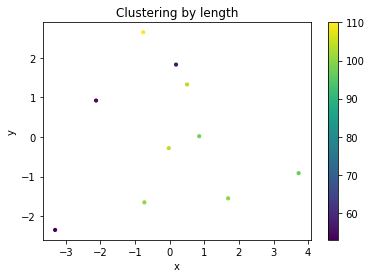

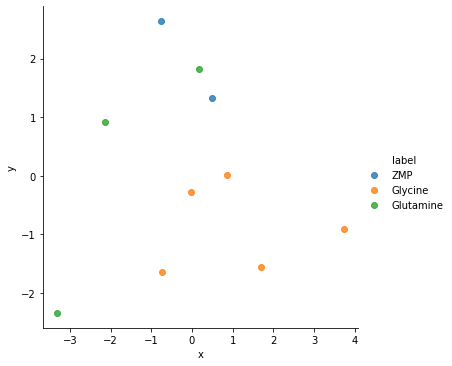

In [41]:
latent_space_total =ls[0]
for i in range(1,len(ls)):
  l = ls[i]
  latent_space_total = np.concatenate((latent_space_total,l), axis=0)

print(latent_space_total.shape)

ys_total =ys[0]
for i in range(1,len(ys)):
  y = ys[i]
  ys_total = np.concatenate((ys_total,y), axis=0)
ys_total = ys_total.argmax(1).reshape(-1,1)

l1_total = l1[0]
for i in range(1, len(l1)):
  l = l1[i]
  l1_total = np.concatenate((l1_total, l), axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(latent_space_total)

ids = []
for i in range(len(sets)):
  ids.append(i)

l_di = dict(zip(ids, sets))

ribo_labels = pd.DataFrame(ys_total)
ribo_labels = ribo_labels.replace(l_di)

pcs = pd.DataFrame(pcs)

pcs_data = pd.concat((pcs, ribo_labels), axis=1)
pcs_data.columns = ['x', 'y', 'label']

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(pcs_data['x'], pcs_data['y'], c=l1_total, s=10)
ax.set_title('Clustering by length')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

import seaborn as sns

facet = sns.lmplot(data=pcs_data, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

#compare

In [253]:
from Bio.Align import substitution_matrices
from Bio import pairwise2

blosum62 = substitution_matrices.load('BLOSUM62')
aligner = Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.mode = 'global'

variability = 0.0
number_samples = 1
test_index = random.sample(range(len(valid_index)), 10)
rnnvae_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = 1)
for i, (x,y,l) in enumerate(rnnvae_test_loader):
  x1 = x.reshape(x.size(0), 4*x.size(1))
  a,_ = process_generated(x1)
  print('\n >KF99 UM2020 \n', a)
  latent_space_rnn = rnnvae.encode(x,y)
  latent_space_vae = vae.encode(x1)
  
  for i in range(number_samples):
    noise = torch.randn((latent_space_rnn.shape))*variability
    noise = noise.double().to(device)
    sampled_rnn = noise+latent_space_rnn
    sampled_vae = noise+latent_space_vae
    gen_rnn = rnnvae.generate_similar(sampled_rnn, y)
    gen_vae = vae.generate_similar(sampled_vae, y)
    gen_rnn, gen_code = process_generated(gen=gen_rnn)
    gen_vae, gen_code1 = process_generated(gen=gen_vae)
    rnn_score = aligner.align(a, gen_rnn)
    rnn_score = rnn_score.score
    vae_score = aligner.align(a, gen_vae)
    vae_score = vae_score.score
    print('>KF99 RNN \n', gen_rnn)
    print('>KF99 MLP \n', gen_vae)
    print('RNN score: ', rnn_score)
    print('MLP score: ', vae_score)
    print('% improvement: ', 100*(rnn_score-vae_score)/vae_score)

      
    alignment = pairwise2.align.localds(a, gen_rnn, blosum62, -10, -1)
    ga1 = pairwise2.align.globalxx(a, gen_rnn)
    print( 'ga rnn: ', ga1[0].score)
    print(alignment[0].score)

    alignment2 = pairwise2.align.localds(a, gen_vae, blosum62, -10, -1)
    ga2 = pairwise2.align.globalxx(a, gen_vae)
    print('ga mlp: ', ga2[0].score)
    print(alignment2[0].score)

print(latent_space)


 >KF99 UM2020 
 CGCCCTCGTGCGGGAGAGCTCCGTGACCGCCAGCCACGGACGCCGAAGGAGCAATACCTCTCCGTCAACCTCTCAGGCACCCAGGACCGCGCCAGGCCC


RuntimeError: ignored

In [ ]:

blosum62 = substitution_matrices.load('BLOSUM62')
aligner = Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.mode = 'global'

score1rnn = []
score1mlp = []
score2rnn = []
score2mlp = []
score3rnn = []
score3mlp = []

variability = 0.0
number_samples = 1
test_index = random.sample(range(len(valid_index)), 30)
rnnvae_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = 1)
for i, (x,y,l) in enumerate(rnnvae_test_loader):
  print(i/len(rnnvae_test_loader)*100, '%')
  x1 = x.reshape(x.size(0), 4*x.size(1))
  a,_ = process_generated(x1)
  latent_space_rnn = rnnvae.encode(x,y)
  latent_space_vae = vae.encode(x1)
  
  for i in range(number_samples):
    noise = torch.randn((latent_space_rnn.shape))*variability
    noise = noise.double().to(device)
    sampled_rnn = noise+latent_space_rnn
    sampled_vae = noise+latent_space_vae
    gen_rnn = rnnvae.generate_similar(sampled_rnn, y)
    gen_vae = vae.generate_similar(sampled_vae, y)
    gen_rnn, _ = process_generated(gen=gen_rnn)
    gen_vae, _ = process_generated(gen=gen_vae)

    rnn_score = aligner.align(a, gen_rnn)
    rnn_score = rnn_score.score
    score1rnn.append(rnn_score)
    vae_score = aligner.align(a, gen_vae)
    vae_score = vae_score.score
    score1mlp.append(vae_score)



    rnn2 = pairwise2.align.localds(a, gen_rnn, blosum62, -10, -1)
    score2rnn.append(rnn2[0].score)
    mlp2 = pairwise2.align.localds(a, gen_vae, blosum62, -10, -1)
    score2mlp.append(mlp2[0].score)


    rnn3 =  pairwise2.align.globalxx(a, gen_rnn)
    score3rnn.append(rnn3[0].score)
    mlp3 =  pairwise2.align.globalxx(a, gen_vae)
    score3mlp.append(mlp3[0].score)


In [ ]:
print(mean(score1rnn), mean(score1mlp))
print(mean(score2rnn), mean(score2mlp))
print(mean(score3rnn), mean(score3mlp))



In [ ]:

a,b = np.asarray(score1rnn), np.asarray(score1mlp)
dif1 = a-b
a,b = np.asarray(score2rnn), np.asarray(score2mlp)
dif2 = a-b
a,b = np.asarray(score3rnn), np.asarray(score3mlp)
dif3 = a-b

print(np.mean(dif2), np.std(dif2))

#Non-functional architectures


## RNN-MLP vae

https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb

In [ ]:
 class VAE(nn.Module):
    def __init__(self, in_dims=1, hid1_dims=1, hid2_dims=8, num_classes=num_classes, negative_slope=0.1):
        super(VAE, self).__init__()
        self.in_dims = in_dims
        self.hid1_dims = hid1_dims
        self.hid2_dims = hid2_dims
        self.num_classes = num_classes
        self.negative_slope = negative_slope
        
        self.gru = nn.GRU(input_size=4, hidden_size= 128, num_layers= 1, bidirectional= True, batch_first = True)
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_dims, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU() #nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
        )

        self.combine = nn.Sequential(
            nn.Linear(128+256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU()
        )
        self.fc_mu = nn.Linear(128, hid1_dims)
        self.fc_var = nn.Linear(128, hid1_dims)

        # Conditioner
        self.conditioner = nn.Sequential(
            nn.Linear(num_classes, 16),
            nn.ReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(16,32),
            nn.ReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(32, hid2_dims),
            nn.ReLU() #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hid1_dims, 128), 
            nn.BatchNorm1d(128),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(512, 512), 
            nn.BatchNorm1d(512),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(512, in_dims),
            nn.Sigmoid()
        )

        self._init_weights()

    def forward(self, x, y):
        _, h = self.gru(x) ##, self.hidden)
        h = h.permute(1,2,0).contiguous()
        h1 = torch.flatten(h, start_dim=1, end_dim = 2).contiguous()
        # Encode input
        # Encode input
        x = x.reshape(x.size(0), 4*x.size(1))
        h2 = self.encoder(x)
        h = torch.cat((h1,h2), dim=1)
        h = self.combine(h)
        mu, logvar = self.fc_mu(h), self.fc_var(h)
        hx = self._reparameterize(mu, logvar)
        # Encode label
        
        hy = self.conditioner(y)
        # Hidden representation
        h = torch.cat([hx, hy], dim=1)
        #print('hx:', hx.shape, 'hy:', hy.shape, 'y:', y.shape)
        h = torch.cat([hx,y], dim = 1)
        # Decode
        y_ = self.decoder(hx)
        return y_, mu, logvar

    def generate(self, y):
        hy = self.conditioner(y)
        hx = self._sample(y.shape[0]).type_as(hy)
        h = torch.cat([hx, hy], dim=1)
        h = torch.cat([hx,y], dim = 1)
        y = self.decoder(hx)
        return y
    def generate_similar(self,l,y):
      h = torch.cat([l,y], dim=1)
      z = self.decoder(l)
      return(z)


    def encode(self, x):
      l1 = self.encoder(x)
      mu, logvar = self.fc_mu(l1), self.fc_var(l1)
      l2 = self._reparameterize(mu, logvar)
      return l2

    def _represent(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_var(h)
        hx = self._reparameterize(mu, logvar)
        return hx

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).type_as(mu)
        z = mu + std * esp
        return z


    def _sample(self, num_samples):
        return torch.FloatTensor(num_samples, self.hid1_dims).normal_()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [ ]:
# return reconstruction error + KL divergence losses
def vae_loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x.flatten(), x.flatten(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) 
    return BCE + 1.0*KLD #see Serena Yeung et. al. for KL scaling factor explanation

In [ ]:
def train_vae(epoch, opt, loader):
  train_loader = loader
  vae.train()
  train_loss = 0
  for batch_idx, (x,c, l) in enumerate(train_loader):
      opt.zero_grad()
      #x = x.reshape(x.size(0), 4*x.size(1))
      recon_batch, mu, log_var = vae(x,c)
      loss = vae_loss_function(recon_batch, x, mu, log_var)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(vae.parameters(), 4)
      train_loss += loss.item()
      opt.step()
        

  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test_vae(epoch, loader):
  test_load = loader
  vae.eval()
  test_loss = 0
  for batch_idx, (x,c, l) in enumerate(test_load):
      #x = x.reshape(x.size(0), 4*x.size(1))
      recon_batch, mu, log_var = vae(x,c)
      loss = F.binary_cross_entropy(recon_batch.flatten(), x.flatten(), reduction='sum')
      test_loss += loss.item()

        

  print('====> test loss: {:.4f}'.format(test_loss / len(test_load.dataset)))

In [ ]:
batch_size_vae = 100
vae_epochs = 150
latent_size = 16
conditional_size = 32

In [ ]:
# build model
vae = VAE(in_dims=4*(padded_sequence.size(0)), hid1_dims = latent_size, hid2_dims = conditional_size, num_classes=num_classes, negative_slope=.01).double()
vae = vae.to(device)
optimizer_vae = torch.optim.Adam(vae.parameters(), lr = .001)

In [ ]:
#rng = np.random.default_rng()
#rng.shuffle(vae_index)
train_index = range(len(train_x[0,:,0]))
test_index = random.sample(range(len(valid_index)), 100)
vae_train_loader = data.DataLoader(dataset(train_x[:,train_index,:], train_y[train_index,:], train_length[train_index]), batch_size = batch_size_vae)
vae_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = batch_size_vae)

In [ ]:
for epoch in range(vae_epochs):
    train_vae(epoch, optimizer_vae, vae_train_loader)
    test_vae(epoch, vae_test_loader)

In [ ]:
variability = 0.0
number_samples = 1
test_index = random.sample(range(len(valid_index)), 100)
ys = []
ls = []
l1 = []
vae_test_loader = data.DataLoader(dataset(train_x[:,test_index,:], train_y[test_index,:], train_length[test_index]), batch_size = 1)
for i, (x,y,l) in enumerate(vae_test_loader):
  x1 = x.reshape(x.size(0), 4*x.size(1))
  a,_ = process_generated(x1)
  #print(y)
  latent_space = vae.encode(x1)
  ls.append(latent_space.to('cpu').detach().numpy())
  ys.append(y.to('cpu').detach().numpy())
  l1.append(l.to('cpu').detach().numpy())

  if i <20:
    print('\n >KF99 UM2020 \n', a) 
    for i in range(number_samples):
      noise = torch.randn((latent_space.shape))*variability
      noise = noise.double().to(device)
      sampled = noise+latent_space
      gen = vae.generate_similar(sampled, y)
      gen_seq, gen_code = process_generated(gen=gen)
      print('>KF99 UM202{} \n'.format(i+1), gen_seq )
  else:
    pass

print(latent_space)


In [ ]:
latent_space_total =ls[0]
for i in range(1,len(ls)):
  l = ls[i]
  latent_space_total = np.concatenate((latent_space_total,l), axis=0)

print(latent_space_total.shape)

ys_total =ys[0]
for i in range(1,len(ys)):
  y = ys[i]
  ys_total = np.concatenate((ys_total,y), axis=0)
ys_total = ys_total.argmax(1).reshape(-1,1)

l1_total = l1[0]
for i in range(1, len(l1)):
  l = l1[i]
  l1_total = np.concatenate((l1_total, l), axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(latent_space_total)

ids = []
for i in range(len(sets)):
  ids.append(i)

l_di = dict(zip(ids, sets))

ribo_labels = pd.DataFrame(ys_total)
ribo_labels = ribo_labels.replace(l_di)

pcs = pd.DataFrame(pcs)

pcs_data = pd.concat((pcs, ribo_labels), axis=1)
pcs_data.columns = ['x', 'y', 'label']

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(pcs_data['x'], pcs_data['y'], c=l1_total, s=10)
ax.set_title('Clustering by length')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

import seaborn as sns

facet = sns.lmplot(data=pcs_data, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

##RNNVAE w RNN decoder

In [ ]:
 class RNN_VAERNN(nn.Module):
    def __init__(self, latent_dims=128, num_encoder_layers = 2, encoder_hidden_size = 128 , num_decoder_layers=2, decoder_hidden_size = 128, seqlen = train_x.shape[0], expansion_size= 5):
        super(RNN_VAERNN, self).__init__()
        self.latent_dims = latent_dims
        self.num_decoder_layers = num_decoder_layers
        self.decoder_hidden_size = decoder_hidden_size
        self.num_encoder_layers = num_encoder_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.seqlen = seqlen
        self.expansion_size= expansion_size
        
        self.gru1 = nn.GRU(input_size=4, hidden_size= self.encoder_hidden_size, num_layers= num_encoder_layers, bidirectional= True, dropout=0, batch_first = True)
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(2*self.encoder_hidden_size*self.num_encoder_layers, 256),
            nn.LeakyReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(256,128),
            nn.LeakyReLU(),
        )

        self.fc_mu = nn.Linear(128, latent_dims)
        self.fc_var = nn.Linear(128, latent_dims)
        
        self.latent_to_seq= nn.Sequential(
            nn.Linear(self.latent_dims, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, self.expansion_size*self.seqlen),
            nn.Sigmoid(),
        )

        self.latent_to_hidden = nn.Sequential(
            nn.Linear(self.latent_dims, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.decoder_hidden_size*self.num_decoder_layers*2)
        )
        self.hidden_to_output = nn.Sequential(
            nn.Linear(self.decoder_hidden_size*2, 256), 
            nn.LeakyReLU(),
            #nn.Linear(256, 128),
            #nn.ReLU(),
            nn.Linear(256, 4),
            nn.Sigmoid())
    

        self.decoder = nn.GRU(self.expansion_size, self.decoder_hidden_size, self.num_decoder_layers, bidirectional=True, batch_first = True)
       
        self._init_weights()



    def forward(self, x, y):
        
        gru_out, h = self.gru1(x)
        hp = h.permute(1,2,0)
        hf = torch.flatten(hp, start_dim=1, end_dim = 2)
        hx = self.encoder(hf)
        mu, logvar = self.fc_mu(hx), self.fc_var(hx)
        hx = self._reparameterize(mu, logvar)
        lin_seq = self.latent_to_seq(hx)
        lin_seq = torch.reshape(lin_seq, (lin_seq.size(0), int(lin_seq.size(1)/self.expansion_size), self.expansion_size)).contiguous()
        lin_seq = lin_seq.clone()
        hid = self.latent_to_hidden(hx)
        hid = torch.reshape(hid, [hid.size(0), 2*self.num_decoder_layers, self.decoder_hidden_size]).contiguous()
        hid = hid.permute(1,0,2).contiguous()
        decoder_output, _ = self.decoder(lin_seq, hid) ###, h)
        y = self.hidden_to_output(decoder_output)
        return y, mu, logvar

    def generate(self, y):

        lin_seq = self.latent_to_seq(y)
        lin_seq = torch.reshape(lin_seq, (lin_seq.size(0), int(lin_seq.size(1)/self.expansion_size), self.expansion_size)).contiguous()
        lin_seq = lin_seq.clone()
        hid = self.latent_to_hidden(y)
        hid = torch.reshape(hid, [hid.size(0), 2*self.num_decoder_layers, self.decoder_hidden_size]).contiguous()
        hid = hid.permute(1,0,2).contiguous()
        decoder_output, _ = self.decoder(lin_seq, hid)
        y = self.hidden_to_output(decoder_output)

        return y

    def generate_similar(self,l,y):

        lin_seq = self.latent_to_seq(l)
        lin_seq = torch.reshape(lin_seq, (lin_seq.size(0), int(lin_seq.size(1)/self.expansion_size), self.expansion_size)).contiguous()
        lin_seq = lin_seq.clone()
        hid = self.latent_to_hidden(l)
        hid = torch.reshape(hid, [hid.size(0), 2*self.num_decoder_layers, self.decoder_hidden_size]).contiguous()
        hid = hid.permute(1,0,2).contiguous()
        decoder_output, _ = self.decoder(lin_seq, hid)
        z = self.hidden_to_output(decoder_output)

        return z


    def encode(self, x):
        ##self.hidden = self.init_hidden(x.size(0)).to(device)
        gru_out, h = self.gru1(x) ##, self.hidden)
        h = h.permute(1,2,0)
        h = torch.flatten(h, start_dim=1, end_dim = 2)
        # Encode input
        h2 = self.encoder(h)
        mu, logvar = self.fc_mu(h2), self.fc_var(h2)
        l2 = self._reparameterize(mu, logvar)

        return l2

    def _represent(self, x):
         ##self.hidden = self.init_hidden(x.size(0)).to(device)
        gru_out, h = self.gru(x) ##, self.hidden)
        h = h.permute(1,2,0)
        h = torch.flatten(h, start_dim=1, end_dim = 2)
        # Encode input
        h2 = self.encoder(h)
        mu, logvar = self.fc_mu(h2), self.fc_var(h2)
        hx = self._reparameterize(mu, logvar)

        return hx

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).type_as(mu)
        z = mu + std * esp
        return z


    def _sample(self, num_samples):
        return torch.FloatTensor(num_samples, self.latent_dims).normal_()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [ ]:
# return reconstruction error + KL divergence losses
def rnnvae2_loss_function(recon_x, x, mu, log_var, epo):
    BCE = F.binary_cross_entropy(recon_x.flatten(), x.flatten(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) #*np.sqrt(epo/vae_epochs)
    return BCE + 0*KLD #see Serena Yeung et. al. for KL scaling factor explanation


In [ ]:
def train_rnn_vae2(epoch, opt, loader):
  train_loader = loader
  rnnvae2.train()
  train_loss = 0
  for batch_idx, (x,c,l) in enumerate(train_loader):
      opt.zero_grad()
      #x = x.reshape(x.size(0), 4*x.size(1))
      x = x.double().to(device)
      recon_batch, mu, log_var = rnnvae2(x,c)
      #print(recon_batch.shape, x.shape)
      #recon_batch = recon_batch.permute(1,0,2).double().to(device)
      loss = rnnvae2_loss_function(recon_batch, x, mu, log_var, epoch)
      loss.backward()
      train_loss += loss.item()
      opt.step()
        

  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test_rnnvae2(epoch, loader):
  test_load = loader
  rnnvae2.eval()
  test_loss = 0
  for batch_idx, (x,c,l) in enumerate(test_load):
      #x = x.reshape(x.size(0), 4*x.size(1))
      recon_batch, mu, log_var = rnnvae2(x,c)

      loss = F.binary_cross_entropy(recon_batch.flatten(), x.flatten(), reduction='sum')
      test_loss += loss.item()

        

  print('====> test loss: {:.4f}'.format(test_loss / len(test_load.dataset)))

In [ ]:
batch_size_vae = 200
vae_epochs = 100
train_index = range(len(train_x[0,:,0]))
#train_index = random.sample(range(train_x.shape[1]), 200)
test_index = random.sample(range(len(valid_index)), 100)
vae_train_loader = data.DataLoader(dataset(train_x[:,train_index,:], train_y[train_index,:], train_length[train_index]), batch_size = batch_size_vae)
vae_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = batch_size_vae)

In [ ]:
# build model
latent_size = 16
encode_layers = 1
encode_hsize = 128
decode_layers = 1
decode_hsize = 128
expansion_size = 5

rnnvae2 = RNN_VAERNN(latent_dims = latent_size, num_encoder_layers=encode_layers, encoder_hidden_size=encode_hsize, num_decoder_layers=decode_layers, decoder_hidden_size=decode_hsize, seqlen=train_x.shape[0], expansion_size=expansion_size).double()
rnnvae2 = rnnvae2.to(device)
optimizer_vae2 = torch.optim.Adam(rnnvae2.parameters(), lr = .001)

In [ ]:
for epoch in range(vae_epochs):
    train_rnn_vae2(epoch, optimizer_vae2, vae_train_loader)
    test_rnnvae2(epoch, vae_test_loader)

In [ ]:
#without ReLU in pseudoseq
#train = 173
#test  = 172

In [ ]:
variability = 0.0
number_samples = 1
test_index = random.sample(range(len(valid_index)), 10)
rnnvae2_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = 1)
for i, (x,y,l) in enumerate(rnnvae2_test_loader):
  x1 = x.reshape(x.size(0), 4*x.size(1))
  a,_ = process_generated(x1)
  print(y)
  print(a)
  latent_space = rnnvae2.encode(x)
  
  for i in range(number_samples):
    noise = torch.randn((latent_space.shape))*variability
    noise = noise.double().to(device)
    sampled = noise+latent_space
    gen = rnnvae2.generate(sampled)
    gen_seq, gen_code = process_generated(gen=gen)
    print(gen_seq)

print(latent_space)
print(gen[0,:10,:])

In [ ]:
variability = 0.0
number_samples = 1
test_index = random.sample(range(len(valid_index)), 10)
rnnvae_test_loader = data.DataLoader(dataset_rnn(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = 1)
for i, (x,y,l) in enumerate(rnnvae_test_loader):
  l = l.to('cpu')
  x = x.double().to(device)
  pack = torch.nn.utils.rnn.pack_padded_sequence(x, l , batch_first=True, enforce_sorted=False)
  x1 = x.reshape(x.size(0), 4*x.size(1))
  a,_ = process_generated(x1)
  print('\n >KF99 UM2020 \n', a)
  latent_space = rnnvae2.encode(x)
  
  for i in range(number_samples):
    noise = torch.randn((latent_space.shape))*variability
    noise = noise.double().to(device)
    sampled = noise+latent_space
    gen = rnnvae2.generate_similar(sampled, y)
    gen_seq, gen_code = process_generated(gen=gen)
    print('>KF99 UM2021 \n', gen_seq)

print(latent_space)


##seq2seq

In [ ]:
def seq2seq_loss(recon_x, x, mu, log_var, epo):
  BCE = F.binary_cross_entropy(recon_x.flatten(), x.flatten(), reduction='sum')
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())*np.sqrt(epo/seq2seq_epochs)
  return BCE + 1*KLD #see Serena Yeung et. al. for KL scaling factor explanation

In [ ]:
 class EncoderRNN(nn.Module):
    def __init__(self, hidden_size=64, latent_size=128, num_layers = 1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size=4, hidden_size= self.hidden_size, num_layers= self.num_layers, bidirectional= True, dropout=0, batch_first = True)
        self.encoder = nn.Sequential(
            nn.Linear(2*self.hidden_size*self.num_layers, 128),
            nn.ReLU(), #nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Linear(128,128),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(128, latent_size)
        self.fc_var = nn.Linear(128, latent_size)


        self._init_weights()

    def forward(self, x):
        ##self.hidden = self.init_hidden(x.size(0)).to(device)
        gru_out, h = self.gru(x) ##, self.hidden)
        h = h.permute(1,2,0)
        h = torch.flatten(h, start_dim=1, end_dim = 2)
        # Encode input
        h2 = self.encoder(h)
        mu, logvar = self.fc_mu(h2), self.fc_var(h2)
        hx = self._reparameterize(mu, logvar)

        return hx, mu, logvar


    def _represent(self, x):
         ##self.hidden = self.init_hidden(x.size(0)).to(device)
        gru_out, h = self.gru(x) ##, self.hidden)
        h = h.permute(1,2,0)
        h = torch.flatten(h, start_dim=1, end_dim = 2)
        # Encode input
        h2 = self.encoder(h)
        mu, logvar = self.fc_mu(h2), self.fc_var(h2)
        hx = self._reparameterize(mu, logvar)
        return hx

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).type_as(mu)
        z = mu + std * esp
        return z


    def _sample(self, num_samples):
        return torch.FloatTensor(num_samples, self.latent_size).normal_()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, layers, output_size = 4):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.gru = nn.GRU(4, hidden_size, num_layers=self.layers, bidirectional = False, batch_first=True)
        self.out = nn.Sequential(
            nn.Linear(hidden_size, 128), 
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Sigmoid())
          
        self.softmax = nn.Softmax(dim=2) #sub for softmax?
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)

        output = self.out(output) #output[0]? 
      
        return output, hidden



In [ ]:
dec = DecoderRNN(hidden_size=128, layers=2)
h = torch.randn([2,100,128])
input = torch.randn([100,19,4])
i = input[:,0,:]
i = i.unsqueeze(1)
s = torch.zeros_like(input)
for ij in range(19):

  out, h = dec(i,h)
  s[:,ij,:] = out[:,-1,:]
  i = input[:,:ij+1,:]



In [ ]:
class Seq2seq(nn.Module):
  def __init__(self, encoder, decoder, decode_layers, lsize, hsize):
    super(Seq2seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.latent_to_hidden = nn.Linear(lsize , hsize)

  def forward(self, input, teacher_forcing):

    latent, mu, log_var = self.encoder(input)

    new_hidden = self.latent_to_hidden(latent)
    #new_hidden = latent


    tensor_length = input.size(1)

    outputs = torch.zeros_like(input)

    use_teacher_forcing = True if random.random() < teacher_forcing else False

    ##decoder_input = input[:,0,:]
    ##decoder_input = torch.unsqueeze(decoder_input, dim=1)
    decoder_input = torch.zeros([input.size(0), 1, input.size(2)], requires_grad=True).double().to(device)

    decoder_hidden = torch.stack([new_hidden for _ in range(decode_layers)], dim=0)

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(tensor_length):
            #print('decode input:', decoder_input.shape)
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
           
            outputs[:,di,:] = decoder_output[:,-1,:]
            decoder_input = input[:,:di+1,:].clone()
          

            ##decoder_input = input[:,di,:]  # Teacher forcing
            ##decoder_input = torch.unsqueeze(decoder_input, dim=1)

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(tensor_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            outputs[:,di,:] = decoder_output[:,-1,:]
            decoder_input = outputs[:,:di+1,:].clone()
            #decoder_input = decoder_input.detach()  # detach from history as input


    return outputs, latent, mu, log_var



In [ ]:
a = torch.tensor([[3,3,3], [2,2,2]] )
a[-1,:]

In [ ]:
def train_seq2seq1(model, loader, optimizer, epoch):
  model.train()
  train_loss = 0

  for i, (x,y,l) in enumerate(loader):
    optimizer.zero_grad()
    x = x.double().to(device)
    reconstructed, latent, mu, log_var = model(x, 1-.5*np.sqrt(epoch/seq2seq_epochs))
    loss = seq2seq_loss(reconstructed, x, mu, log_var, epoch)
    loss.backward()

    optimizer.step()
    train_loss += loss.item()


  print('\n ====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(loader.dataset)))
  return reconstructed, x

In [ ]:
def evaluate(model, loader, epoch):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (x,y,l) in enumerate(loader):
            x = x.double().to(device)

            output, latent, mu, logvar = model(x, 0) #turn off teacher forcing

            loss = seq2seq_loss(output, x, mu, logvar, epo=0)
            
            epoch_loss += loss.item()
        print(' ====> Average test loss:     {:.4f}'.format( epoch_loss / len(loader.dataset)))
    return output, x, epoch_loss / len(loader)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        

In [ ]:
a = torch.randn([3,5])
b = torch.zeros_like(a)
for i in range(a.size(0)):
  b[i,:] = a[i,:]

print(b)


In [ ]:
batch_size_vae = 4
seq2seq_epochs = 50
#train_index = range(len(train_x[0,:,0]))
train_index = random.sample(range(train_x.shape[1]), 200)
test_index = random.sample(range(len(valid_index)), 10)
vae_train_loader = data.DataLoader(dataset(train_x[:,train_index,:], train_y[train_index,:], train_length[train_index]), batch_size = batch_size_vae)
vae_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:], test_length[test_index]), batch_size = batch_size_vae)


In [ ]:
latent_size = 3
encode_hidden_size = 128
decode_hidden_size = 256
decode_layers = 2
encoder = EncoderRNN(hidden_size = encode_hidden_size, latent_size=latent_size, num_layers = 2).double().to(device)
decoder = DecoderRNN(hidden_size=decode_hidden_size, layers = decode_layers).double().to(device)
seq2seq = Seq2seq(encoder=encoder, decoder = decoder, decode_layers=decode_layers, lsize = latent_size, hsize = decode_hidden_size).double().to(device)
seq2seq_optimizer = torch.optim.Adam(seq2seq.parameters(), lr=.001)
seq2seq.apply(init_weights)

In [ ]:
with torch.autograd.set_detect_anomaly(True):
  for epoch in range(seq2seq_epochs):
      out = train_seq2seq1(seq2seq, vae_train_loader, seq2seq_optimizer, epoch)
      _,__,test_loss = evaluate(seq2seq, vae_test_loader, epoch)
      

In [ ]:
pred = out[0]
tar = out[1]
print(pred[0, :10,:])
print(tar[0, :10  ,:])

In [ ]:

gen_seq, gen_code = process_generated(gen=pred[1])
seq, _ = process_generated(gen=tar[1])
print(gen_seq)
print(seq)

In [ ]:
variability = 0.0
number_samples = 1
test_index = random.sample(range(len(valid_index)), 10)
rnnvae2_test_loader = data.DataLoader(dataset(test_x[:,test_index,:], test_y[test_index,:]), batch_size = 1)
for i, (x,y) in enumerate(rnnvae2_test_loader):
  x1 = x.reshape(x.size(0), 4*x.size(1))
  a,_ = process_generated(x1)
  print(y)
  print(a)
  latent_space = EncoderRNN.encode(x)
  
  for i in range(number_samples):
    noise = torch.randn((latent_space.shape))*variability
    noise = noise.double().to(device)
    sampled = noise+latent_space
    gen = rnnvae2.generate_similar(sampled, y)
    gen_seq, gen_code = process_generated(gen=gen)
    print(gen_seq)

print(latent_space)
print(gen[:10])

In [ ]:
enc = EncoderRNN(hid1_dims=128)
enc._init_weights()
a = torch.randn([10, 110, 4])
out, mu, log = enc(a)
dec = DecoderRNN(hidden_size=128)
hid = torch.unsqueeze(out, dim=0)
ran = torch.randn([10,1,4])
loss = 0
criter = nn.MSELoss()
for i in range(30):
  outp, hid = dec(ran, hid)
  if i == 0:
    print(outp)
  else:
    ran = outp.detach()
    tar = a[:,i,:]
    loss += criter(tar.flatten(), ran.flatten())


In [ ]:
#1. set up for loop to create many synthetic sequences
#2. convert synthetic sequences to binary and append to real sequences
#3. create new train_loader to incorporate new data
#4. train new RNN on new data

In [ ]:

generated_list = []
generated_id = []
synthetic = []
for ij in range(num_classes):
  print('NEW TYPE')
  gen_type = ij+1
  a = np.array(gen_type).reshape(-1,1)
  b = enc.transform(a).toarray()
  c = torch.tensor(b).double().to(device)
  avg_len = []
  for ii in range(number_samples):
    sample = model.generate(c)

    test = sample.reshape(padded_sequence.size(0),4).to('cpu')
    test = np.asarray(test.detach())

    pred_binary = np.zeros_like(test)
    pred_binary[np.arange(len(test)), test.argmax(1)] = 1

    a = np.sum(test, 1)

    #plt.plot(a)
    #plt.show()

    stop_point = []
    for i, j in enumerate(a):
      if j <=.1:
        stop_point.append(i)

    #print(stop_point[0:4])
    if not stop_point:
      pass
    elif stop_point[0] <= 40:
      pass
    else:
      pred_binary = pred_binary[:stop_point[0],:]
      avg_len.append(stop_point[0])

      s = []
      for i in pred_binary:
        if i[0] == 1:
          s.append('A')
        elif i[1] == 1:
          s.append('C')
        elif i[2] == 1:
          s.append('G')
        elif i[3] == 1:
          s.append('T')

      result = ''
      for element in s:
          result += str(element)

      generated = [result]

      print(generated)
      synthetic.append(generated)
      seq, _ = sequence_one_hot(generated)
      #print(seq.size(0))
      zeros = torch.zeros((padded_sequence.size(0)-seq.size(0),1,4))
      generated_sequence = torch.cat((seq, zeros))


      g = generated_sequence.permute(1,0,2)
      g = g.to(device)
      generated_list.append(g)

      generated_id.append(c)

  # print(len(generated_list))
  # print(mean(avg_len))
a = generated_list[0]
for i in range(1,len(generated_list)):
  a = torch.cat((a,generated_list[i]))

b = a.permute(1,0,2)
synthetic = b.double().to(device)

train_mixed = torch.cat((train_x,synthetic), dim=1)

#print(train_mixed.shape)

a = generated_id[0]
for i in range(1,len(generated_id)):
  a = torch.cat((a, generated_id[i]))

mixed_y = torch.cat((train_y, a))

return train_mixed, mixed_y


In [ ]:
def generate_synthetic(number_samples, model):
  generated_list = []
  generated_id = []
  synthetic = []
  for ij in range(num_classes):
    print('NEW TYPE')
    gen_type = ij+1
    a = np.array(gen_type).reshape(-1,1)
    b = enc.transform(a).toarray()
    c = torch.tensor(b).double().to(device)
    avg_len = []
    for ii in range(number_samples):
      sample = model.generate(c)

      test = sample.reshape(padded_sequence.size(0),4).to('cpu')
      test = np.asarray(test.detach())

      pred_binary = np.zeros_like(test)
      pred_binary[np.arange(len(test)), test.argmax(1)] = 1

      a = np.sum(test, 1)

      #plt.plot(a)
      #plt.show()

      stop_point = []
      for i, j in enumerate(a):
        if j <=.1:
          stop_point.append(i)

      #print(stop_point[0:4])
      if not stop_point:
        pass
      elif stop_point[0] <= 40:
        pass
      else:
        pred_binary = pred_binary[:stop_point[0],:]
        avg_len.append(stop_point[0])

        s = []
        for i in pred_binary:
          if i[0] == 1:
            s.append('A')
          elif i[1] == 1:
            s.append('C')
          elif i[2] == 1:
            s.append('G')
          elif i[3] == 1:
            s.append('T')

        result = ''
        for element in s:
            result += str(element)

        generated = [result]

        print(generated)
        synthetic.append(generated)
        seq, _ = sequence_one_hot(generated)
        #print(seq.size(0))
        zeros = torch.zeros((padded_sequence.size(0)-seq.size(0),1,4))
        generated_sequence = torch.cat((seq, zeros))


        g = generated_sequence.permute(1,0,2)
        g = g.to(device)
        generated_list.append(g)

        generated_id.append(c)

   # print(len(generated_list))
   # print(mean(avg_len))
  a = generated_list[0]
  for i in range(1,len(generated_list)):
    a = torch.cat((a,generated_list[i]))

  b = a.permute(1,0,2)
  synthetic = b.double().to(device)

  train_mixed = torch.cat((train_x,synthetic), dim=1)

  #print(train_mixed.shape)

  a = generated_id[0]
  for i in range(1,len(generated_id)):
    a = torch.cat((a, generated_id[i]))

  mixed_y = torch.cat((train_y, a))

  return train_mixed, mixed_y


In [ ]:
train_mixed, mixed_y = generate_synthetic(100, vae)

In [ ]:
learn_rate_rnn = .001
rnn_epochs = 100
rnn_batch_size = 200
rnn_dropout_rate = .3
rnn_layers = 1
rnn_width = 128
dense_width = 200

In [ ]:

rnn1 = RNN(drop_p = rnn_dropout_rate, num_layers=rnn_layers, h_rnn = rnn_width, fc_layer = dense_width, batch_size=rnn_batch_size).to(device)
rnn1 = rnn1.double()
rnn_optimizer = torch.optim.Adam(rnn1.parameters(), lr=learn_rate_rnn)

rnn_train_index = range(len(train_x[0,:,0]))
rnn_test_index = range(len(test_x[0,:100,0]))
print('new_fold')

train_loader = data.DataLoader(dataset_rnn(train_x[:,rnn_train_index,:], train_y[rnn_train_index,:]), batch_size=rnn_batch_size)
test_loader = data.DataLoader(dataset_rnn(test_x[:,rnn_test_index,:], test_y[rnn_test_index,:]), batch_size=rnn_batch_size)

for epoch in range(rnn_epochs):
  train_losses = train(device, rnn_optimizer, train_loader, rnn1)
  test_loss, y_pred_test1, y_test1= test_rnn(device, test_loader, rnn1)
  avg_train_loss = sum(train_losses)/len(train_losses)
  print('epoch:', epoch, 'loss:', avg_train_loss, "test:", test_loss)

In [ ]:

rnn2 = RNN2(drop_p = rnn_dropout_rate, num_layers=rnn_layers, h_rnn = rnn_width, fc_layer = dense_width, batch_size=rnn_batch_size).to(device)
rnn2 = rnn2.double()
rnn_optimizer2 = torch.optim.Adam(rnn2.parameters(), lr=learn_rate_rnn)

rnn_train_index2 = range(len(train_x[0,:,0]))
rnn_test_index = range(len(train_mixed[0,:100,0]))
print('new_fold')

train_loader = data.DataLoader(dataset_rnn(train_mixed[:,rnn_train_index2,:], mixed_y[rnn_train_index2,:]), batch_size=rnn_batch_size)
test_loader = data.DataLoader(dataset_rnn(test_x[:,rnn_test_index,:], test_y[rnn_test_index,:]), batch_size=rnn_batch_size)

for epoch in range(rnn_epochs):
  train_losses = train(device, rnn_optimizer2, train_loader, rnn2)
  test_loss, y_pred_test2, y_test2 = test_rnn(device, test_loader, rnn2) 
  avg_train_loss = sum(train_losses)/len(train_losses)
  print('epoch:', epoch, 'loss:', avg_train_loss, "test:", test_loss)


In [ ]:
rnn_test_index = range(test_x.shape[1]) #test_x.shape[1])
test_loader = data.DataLoader(dataset_rnn(test_x[:,rnn_test_index,:], test_y[rnn_test_index,:]), batch_size=1000)
_, y_pred_test2, y_test2= test_rnn(device, test_loader, rnn2) 
_, y_pred_test1, y_test1= test_rnn(device, test_loader, rnn1) 


p1, matrix1, avg_auc1, f11 = generate_report(y_pred_test1, y_test1)
p1.show()
print(avg_auc1)
print(matrix1)
p2, matrix2, avg_auc2, f12 = generate_report(y_pred_test2, y_test2)
p2.show()
print(avg_auc2)
print(matrix2)